# Optimization-based Control

In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

In [ ]:
# Parameters
T_final = 100
N = 300  # number of finite-difference intervals (same as nfe=300)
dt = T_final / N

k_rw = 0.1
k_wo = 0.02
k_in = 0.5
T_target = 27
u_tout = 33

# Initial conditions
temp_room_0 = 33
temp_wall_0 = 33

In [ ]:
# Define the ODE right-hand side: x = [temp_room, temp_wall], u = u_in
def ode(x, u):
    temp_room = x[0]
    temp_wall = x[1]
    d_temp_room = -k_rw * (temp_room - temp_wall) + k_in * u
    d_temp_wall = k_rw * (temp_room - temp_wall) - k_wo * (temp_wall - u_tout)
    return ca.vertcat(d_temp_room, d_temp_wall)

In [ ]:
# Build the NLP using backward Euler (matches Pyomo's BACKWARD finite difference)
opti = ca.Opti()

# Decision variables: states at each grid point, controls at each grid point
X = opti.variable(2, N + 1)  # states: [temp_room; temp_wall] at t_0 ... t_N
U = opti.variable(1, N + 1)  # control u_in at t_0 ... t_N

# Initial conditions
opti.subject_to(X[0, 0] == temp_room_0)
opti.subject_to(X[1, 0] == temp_wall_0)

# Control bounds
opti.subject_to(opti.bounded(-0.5, U, 0.5))

In [ ]:
# Dynamics constraints (backward Euler) and running cost
cost = 0
for k in range(N):
    # Backward Euler: x_{k+1} - x_k = dt * f(x_{k+1}, u_{k+1})
    x_next = X[:, k + 1]
    u_next = U[:, k + 1]
    opti.subject_to(x_next - X[:, k] == dt * ode(x_next, u_next))

    # Running cost (trapezoidal quadrature to approximate the integral)
    stage_k = U[:, k] ** 2 + (X[0, k] - T_target) ** 2
    stage_k1 = u_next**2 + (x_next[0] - T_target) ** 2
    cost += 0.5 * dt * (stage_k + stage_k1)

# Terminal cost
cost += (X[0, N] - T_target) ** 2

opti.minimize(cost)

In [ ]:
# Solve with IPOPT
opti.solver("ipopt", {"print_time": False}, {"print_level": 0})
sol = opti.solve()

# Extract solution
t_grid = np.linspace(0, T_final, N + 1)
temp_room_sol = sol.value(X[0, :]).flatten()
temp_wall_sol = sol.value(X[1, :]).flatten()
u_in_sol = sol.value(U).flatten()

print(f"Solver status: optimal")
print(f"Objective value: {sol.value(cost):.4f}")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Solver status: optimal
Objective value: 481.9811


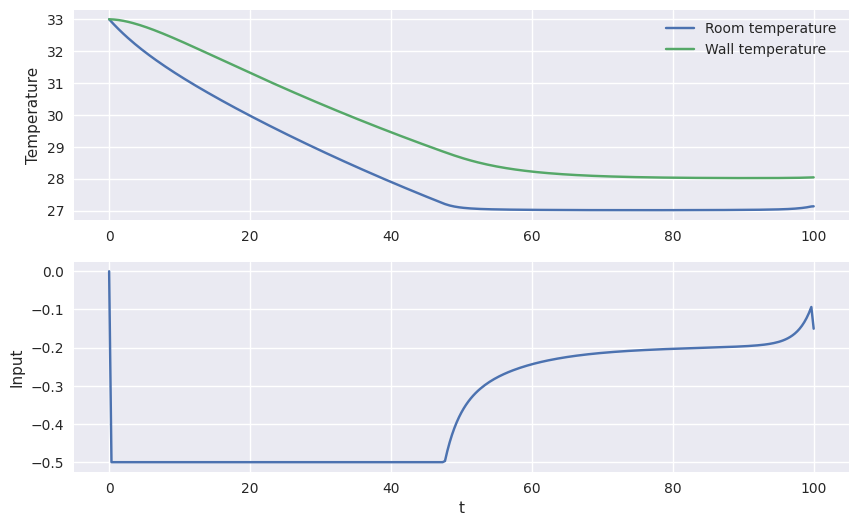

In [ ]:
# Plot the results
fig, axs = plt.subplots(2, 1, figsize=(10, 6))
axs[0].plot(t_grid, temp_room_sol, label="Room temperature")
axs[0].plot(t_grid, temp_wall_sol, label="Wall temperature")
axs[0].set_ylabel("Temperature")
axs[0].legend(loc="best")

axs[1].plot(t_grid, u_in_sol, label="Air conditioner input")
axs[1].set_xlabel("t")
axs[1].set_ylabel("Input")

plt.show()